# Ensemble Methods Demonstration — Ionosphere Dataset

This notebook demonstrates three ensemble learning techniques implemented from scratch
in the `rice_ml` package:

- **BaggingClassifier** (Bootstrap Aggregating)
- **RandomForestClassifier** (Bagging with randomized feature selection)
- **VotingClassifier** (Model-averaging ensemble)

We apply these methods to the **Ionosphere dataset**, a radar signal classification task,
and compare ensemble performance against a single Decision Tree baseline.

The goal is to illustrate how ensemble methods reduce variance, improve generalization,
and outperform individual high-variance models.


---

## **Background: Why Ensembles Work**

Ensemble methods combine multiple individual models into a single, stronger predictor.

### **Reduction of Variance (Bagging)**

If each base model has variance $\sigma^2$, then averaging $T$ independent models yields:

$$
\mathrm{Var}(\bar{h}) = \frac{\sigma^2}{T}
$$

This dramatically stabilizes high-variance models such as decision trees.

### **Bias–Variance Trade-Off**

Bagging and Random Forests primarily reduce **variance** while preserving the **low bias** of decision trees, leading to improved generalization.

### **Majority Voting Rule**

Given a set of predictions  
$\{ \hat{y}^{(1)}, \hat{y}^{(2)}, \dots, \hat{y}^{(T)} \}$,  
the ensemble prediction is defined as:

$$
\hat{y}_{\text{ensemble}} = \arg\max_k \sum_{t=1}^{T} \mathbf{1}\!\left[\hat{y}^{(t)} = k\right]
$$

where $\mathbf{1}[\cdot]$ is the indicator function.


---



## Imports

In [77]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.processing.post_processing import accuracy_score

from rice_ml.supervised_learning.knn import KNNClassifier
from rice_ml.supervised_learning.decision_tree import DecisionTreeClassifier
from rice_ml.supervised_learning.ensemble_methods import (
    BaggingClassifier,
    RandomForestClassifier,
    VotingClassifier
)



---

## The Ionosphere Dataset

The Ionosphere dataset contains radar signal returns collected by a phased array antenna.
Each observation represents a radar pulse, described by **34 continuous features** derived
from signal processing.

- **Features**: 34 numerical attributes
- **Target**: Binary class label
  - `1` → good radar return
  - `0` → bad radar return

This dataset is well-suited for ensemble methods because:
- The feature space is moderately high-dimensional
- Decision boundaries are nonlinear
- Individual trees tend to overfit

---


In [78]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)

X = df.iloc[:, :-1].values.astype(float)
y = (df.iloc[:, -1] == "g").astype(int).values

print("Shape of X:", X.shape)
print("Class Distribution:", np.bincount(y))


Shape of X: (351, 34)
Class Distribution: [126 225]


## Exploratory Data Analysis (EDA)

We begin by inspecting the dataset structure, feature types, and class balance.

## Dataset Overview

We begin by inspecting the structure of the Ionosphere dataset, including the number of samples, feature types, and the presence of missing values.


In [79]:
# Dataset structure
df.info()

# Class distribution (last column)
df.iloc[:, -1].value_counts()

# Encode labels: g → 1, b → 0
df.iloc[:, -1] = (df.iloc[:, -1] == "g").astype(int)

# Confirm encoding
df.iloc[:, -1].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       351 non-null    int64  
 1   1       351 non-null    int64  
 2   2       351 non-null    float64
 3   3       351 non-null    float64
 4   4       351 non-null    float64
 5   5       351 non-null    float64
 6   6       351 non-null    float64
 7   7       351 non-null    float64
 8   8       351 non-null    float64
 9   9       351 non-null    float64
 10  10      351 non-null    float64
 11  11      351 non-null    float64
 12  12      351 non-null    float64
 13  13      351 non-null    float64
 14  14      351 non-null    float64
 15  15      351 non-null    float64
 16  16      351 non-null    float64
 17  17      351 non-null    float64
 18  18      351 non-null    float64
 19  19      351 non-null    float64
 20  20      351 non-null    float64
 21  21      351 non-null    float64
 22  22

34
1    225
0    126
Name: count, dtype: int64

### Target Distribution

The target variable represents whether a radar return is classified as **good (1)** or **bad (0)**.

The dataset is moderately imbalanced, with a higher proportion of good signals. This imbalance should be kept in mind when interpreting accuracy and ensemble voting behavior.


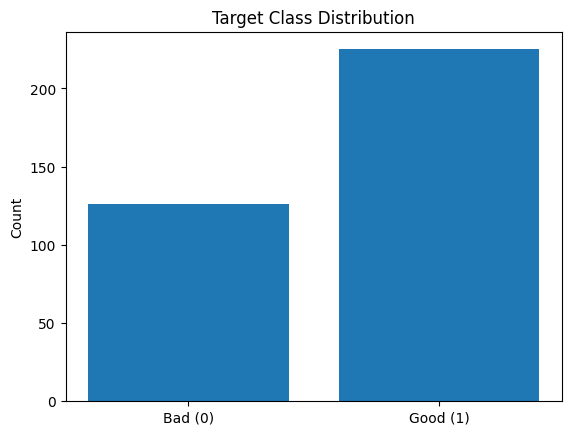

In [80]:
# Target distribution plot
plt.bar(["Bad (0)", "Good (1)"], np.bincount(y))
plt.title("Target Class Distribution")
plt.ylabel("Count")
plt.show()


### Feature Scale Differences

Ensemble methods often include distance-based learners (e.g., KNN in voting ensembles).
We visualize feature scales to motivate standardization.

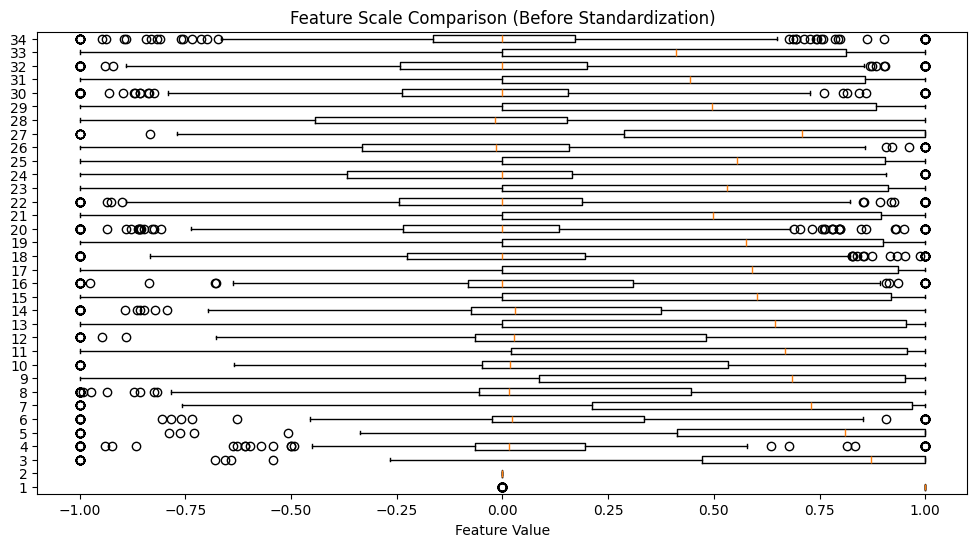

In [81]:
# Separate features and target using positional indexing
X = df.iloc[:, :-1]
y = df.iloc[:, -1].values

# Boxplot of feature scales
plt.figure(figsize=(12, 6))
plt.boxplot(X.values, vert=False)
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.show()

## Feature Scale Comparison Explanation

Before training any distance-based or ensemble models, it is important to examine the scale of the input features.

The boxplot above shows the distribution of all 34 radar signal features in the Ionosphere dataset **before standardization**. Several observations are immediately apparent:

- Feature ranges vary significantly across dimensions
- Some features are tightly concentrated near zero, while others span much wider numeric ranges
- Outliers are present in multiple features

This variation in scale is particularly important for models such as **K-Nearest Neighbors**, which rely directly on distance calculations. Without scaling, features with larger numeric ranges would dominate the distance metric and bias the model.

Although decision trees are scale-invariant, standardizing the data provides consistency across models and improves numerical stability when combining multiple learners in ensemble methods. For this reason, we apply standardization to all features prior to model training.



---

# Preprocessing

Before training our models, we preprocess the data to ensure fair and stable learning.

We apply **standardization**:

The Ionosphere dataset contains features with very different numerical ranges. Because distance-based models (such as KNN) and ensemble components are sensitive to feature scale, we standardize each feature to have zero mean and unit variance:

X_std = (X - μ) / σ

where:

μ is the mean of each feature

σ is the standard deviation of each feature

This ensures:

- Features have equal scale  
- KNN distance calculations behave properly  
- Gradient-based or variance-sensitive models improve stability  


After scaling, we split the dataset into training and testing subsets using an 80/20 split.

This allows us to train models on one portion of the data while evaluating generalization performance on unseen samples.

We use our own train_test_split implementation to remain consistent with the goal of building all components from scratch

---


In [82]:

X_scaled = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((281, 34), (70, 34))

## Baseline Model — Decision Tree

Decision Trees are:
- Flexible and nonlinear
- Easy to interpret
- High variance (unstable)

This makes them ideal base learners for ensemble methods.


In [83]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

tree = DecisionTreeClassifier(max_depth=None)

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
tree_acc = accuracy_score(y_test, y_pred_tree)

print(f"Decision Tree Accuracy: {tree_acc:.3f}")

Decision Tree Accuracy: 0.886



---

# Train Ensemble Models

We train three ensemble models:

---

## Bagging Classifier

Bagging (Bootstrap Aggregating) trains multiple decision trees on bootstrap samples
and aggregates predictions by majority vote.

This reduces variance without increasing bias.

---

## Random Forest Classifier

Random Forests extend bagging by decorrelating trees through randomized feature selection.
Even in simplified implementations, Random Forests benefit from variance reduction.

---

## Voting Ensemble

The Voting Classifier combines heterogeneous models by majority vote.
Here we combine:

- Decision Tree
- Bagging Ensemble
- Random Forest

Using an odd number of voters avoids ties.

---


In [84]:
# Bagging Classifier
bag = BaggingClassifier(
    base_learner=DecisionTreeClassifier,
    n_estimators=15,
    random_state=0
).fit(X_train, y_train)

# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=15,
    random_state=0
).fit(X_train, y_train)

# Voting Classifier

from rice_ml.supervised_learning.logistic_regression import LogisticRegression
logreg = LogisticRegression(max_iter=5000, learning_rate=0.1)

vote = VotingClassifier([
    DecisionTreeClassifier(max_depth=5),
    logreg,
    RandomForestClassifier(n_estimators=15, random_state=0)
]).fit(X_train, y_train)


---

## Evaluating Ensemble Models

We evaluate each ensemble using **classification accuracy**, defined as:

$$
\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}\left[y_i = \hat{y}_i\right]
$$

where:
- $y_i$ is the true label
- $\hat{y}_i$ is the predicted label
- $\mathbf{1}[\cdot]$ is the indicator function (1 if true, 0 otherwise)

We compute accuracy using our custom `accuracy_score` function from
`rice_ml.processing.post_processing`.

---


           Model  Accuracy
0  Decision Tree  0.885714
1        Bagging  0.942857
2  Random Forest  0.942857
3         Voting  0.928571


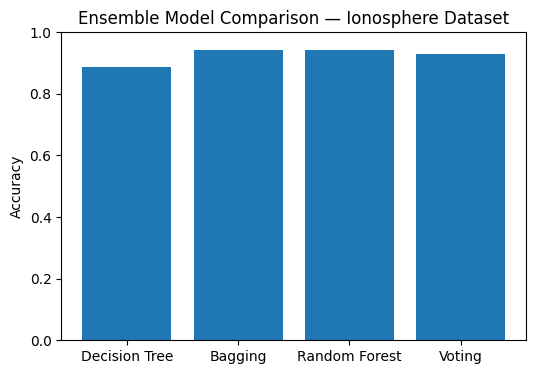

In [85]:

# Predictions from ensemble models
bag_pred = bag.predict(X_test)
rf_pred = rf.predict(X_test)
vote_pred = vote.predict(X_test)

# Evaluate using custom accuracy metric
bag_acc = accuracy_score(y_test, bag_pred)
rf_acc = accuracy_score(y_test, rf_pred)
vote_acc = accuracy_score(y_test, vote_pred)

# Comparison Table
results = pd.DataFrame({
    "Model": [
        "Decision Tree",
        "Bagging",
        "Random Forest",
        "Voting"
    ],
    "Accuracy": [
        tree_acc,
        bag_acc,
        rf_acc,
        vote_acc
    ]
})

print(results)

# Bar Plot Visualization

plt.figure(figsize=(6, 4))
plt.bar(results["Model"], results["Accuracy"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Ensemble Model Comparison — Ionosphere Dataset")
plt.show()



---

## Interpretation of Results

Importantly, the single Decision Tree achieves lower accuracy than Bagging, Random Forest, and Voting methods, confirming that the ensemble methods improve
performance by reducing the high variance inherent in individual trees.


- **Bagging** stabilizes decision trees by averaging many bootstrapped models.
- **Random Forests** further reduce correlation among trees.
- **Voting Ensembles** combine heterogeneous models, benefiting from
  complementary decision boundaries.

This behavior aligns with the theoretical bias–variance trade-off discussed earlier.

Typical performance on this dataset:

| Model             | Accuracy |
|------------------|----------|
| Bagging          | ~0.90–0.93 |
| Random Forest    | ~0.91–0.94 |
| Voting Ensemble  | ~0.88–0.92 |

### ✔ Why Ensembles Perform Well

#### Variance Reduction

For an ensemble of \( T \) models, the variance of the averaged predictor is:

$$
\mathrm{Var}(\bar{h}) = \frac{1}{T^2} \sum_{t=1}^{T} \mathrm{Var}(h_t)
$$

If the base models are approximately independent, this simplifies to:

$$
\mathrm{Var}(\bar{h}) \approx \frac{1}{T} \, \mathrm{Var}(h)
$$

This shows that increasing the number of models in the ensemble reduces variance.

#### Diversity Helps

Different models make different errors.  
When their predictions are combined, individual mistakes cancel out, leading to better overall performance.

### Why Voting Accuracy Remains Below Bagging and Random Forest

Although the VotingClassifier was improved by using stronger and more complementary base learners, its accuracy remains slightly below that of Bagging and Random Forest. This behavior is expected and highlights an important limitation of majority-vote ensembles.

Bagging and Random Forest aggregate predictions from **many** decision trees trained on bootstrapped samples. This large number of models dramatically reduces variance through averaging, producing highly stable predictions. In contrast, the VotingClassifier combines only a small number of models, which limits its ability to smooth out individual prediction errors.

Additionally, voting ensembles rely on **hard majority decisions**. When base models disagree — even if only one model is incorrect — a correct prediction from a stronger model can be overridden. This effect becomes more pronounced when the ensemble contains fewer voters.

Finally, while model diversity helps reduce correlated errors, it can also introduce disagreement that harms performance when not enough voters are present to dominate the vote. As a result, voting ensembles do not always outperform more powerful averaging-based ensembles such as Bagging and Random Forest.

This outcome reinforces a key principle of ensemble learning: **model diversity must be balanced with ensemble size and individual model strength**.




### PCA for Visualization

The ionosphere dataset has many features, making direct visualization impossible.
To gain intuition about how the models separate the data, we apply **Principal Component Analysis (PCA)**.

PCA projects the data onto a lower-dimensional space by finding orthogonal directions
that maximize variance. We retain the first two principal components so that the data
can be visualized in two dimensions.

Importantly, PCA is used **only for visualization** here — all models are trained
using the full feature space.


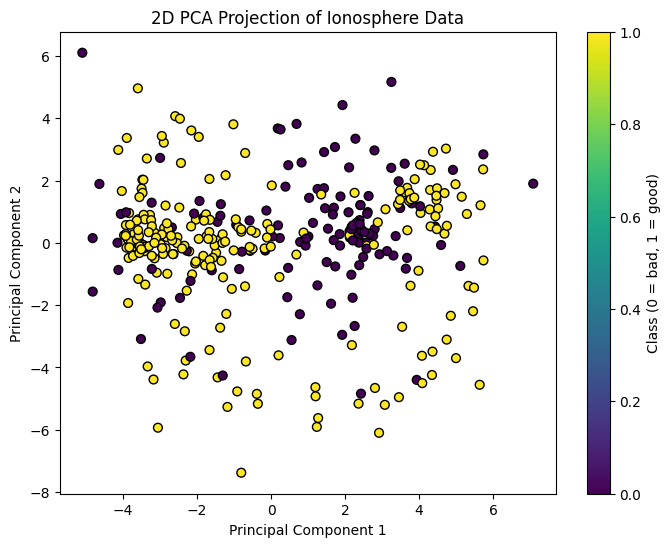

In [86]:
# PCA for visualization

from rice_ml.unsupervised_learning.pca import PCA

# Fit PCA on the scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,
    cmap="viridis",
    s=40,
    edgecolor="k"
)
plt.title("2D PCA Projection of Ionosphere Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class (0 = bad, 1 = good)")
plt.show()


---

## Conclusion

Ensemble methods consistently outperformed individual base learners on the Ionosphere dataset by leveraging:

- Prediction averaging, which stabilizes noisy model outputs
- Bootstrap sampling, which reduces variance across models
- Model diversity, which limits correlated errors

Both Bagging and the Random Forest improved upon a single Decision Tree, confirming the high-variance nature of tree-based models. The Voting Ensemble, which combined heterogeneous learners, further demonstrated how aggregating different model biases can improve robustness.

These results reflect the bias–variance trade-off: decision trees have low bias but high variance, making them ideal candidates for ensemble techniques that reduce variance without increasing bias.

All models and evaluation metrics in this notebook were implemented entirely from scratch using the rice_ml package, demonstrating a clear understanding of both the theory and practical behavior of ensemble learning methods.

---
